# TRAIN PASSENGER DEMAND PREDICTION

### Importing the required libriaries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sin, cos, sqrt, atan2, radians

%matplotlib inline

### Loading Data

In [2]:
cwd = r"D:\Narendra\Hitachi data Engineer Challenge\DataSet"
train_data = pd.read_csv(cwd + "/train.csv")
test_data = pd.read_csv(cwd + "/test.csv")
columns=train_data.drop(['id_code', 'target'], axis=1).columns
tot_data = pd.concat([train_data[columns], test_data[columns]])

## Data Cleansing and Feature Engineering 

### Creating a Datetime column from the data

In [3]:
train_data['current_datetime'] = pd.to_datetime(train_data['current_date']+' '+train_data['current_time'])
train_data['datetime'] = pd.to_datetime(train_data['current_date']+' '+train_data['current_time'])
test_data['current_datetime'] = pd.to_datetime(test_data['current_date']+' '+test_data['current_time'])
test_data['datetime'] = pd.to_datetime(test_data['current_date']+' '+test_data['current_time'])
train_columns = train_data.columns

## Creating the Data Model with Station, Country, date Dimensions and Train details as Fact 

### Station Dimension

In [4]:
source_station = tot_data[['source_name', 'country_code_source', 'longitude_source', 'latitude_source', 'mean_halt_times_source']]
destination_station = tot_data[['destination_name', 'country_code_destination', 'longitude_destination', 'latitude_destination', 'mean_halt_times_destination']]
source_station.columns=['name', 'country_code', 'latitude', 'longitude', 'mean_halt_times']
destination_station.columns=['name', 'country_code', 'latitude', 'longitude', 'mean_halt_times']

In [5]:
station_detail = pd.concat([source_station, destination_station])
station_detail['id'] = station_detail['name'].apply(lambda x: int(x[8:]))
station_detail = station_detail.drop_duplicates()
station_detail.sort_values('id', inplace=True)
station_detail.reset_index(drop=True, inplace=True)
station_detail = station_detail.fillna(method = 'bfill') #Filling NaN values with nearby sation values
station_detail

,name,country_code,latitude,longitude,mean_halt_times,id
0,station$0,logbp,-0.126061,51.531040,0.000000,0
1,station$1,logbp,-0.126061,51.531040,0.000000,1
2,station$2,logbp,-0.126061,51.531040,0.000000,2
3,station$3,logbp,0.321070,51.443040,0.000000,3
4,station$11,zxdec,6.958823,50.942721,12.540462,11
...,...,...,...,...,...,...
304,station$640,whber,2.999286,50.772072,22.445087,640
305,station$642,whber,2.736343,50.854449,22.445087,642
306,station$643,whber,3.130412,50.949025,35.274566,643
307,station$644,whber,3.212088,50.921149,35.274566,644


In [6]:
station_dict = {}
for x,y in zip(station_detail['name'], station_detail['id']):
    station_dict[x] = y

### Country Dimension 

In [7]:
country_code = station_detail['country_code'].sort_values()
country_code = country_code.drop_duplicates()
country_code.reset_index(drop=True, inplace=True)
country_code = country_code.reset_index(drop=False)
country_code.columns=['id', 'code']
country_code

,id,code
0,0,aqfre
1,1,logbp
2,2,qwnll
3,3,whber
4,4,wsluu
5,5,zxdec


In [8]:
country_dict={}
for x,y in zip(country_code['code'], country_code['id']):
    country_dict[x]=y

### Train details Fact 

In [9]:
train_detail = train_data.loc[:,['id_code', 'current_datetime', 'train_name', 'source_name', 'destination_name', 'target']]
train_detail = train_detail.drop_duplicates()
train_detail.sort_values('current_datetime', inplace=True)
train_detail.reset_index(drop=True, inplace=True)
train_detail.reset_index(inplace=True)
train_detail.rename(columns={'current_datetime':'datetime', 'index':'train_id', 'target':'passenger_demand', 
                             'source_name':'source', 'destination_name': 'destination'}, inplace=True)
train_detail

,train_id,id_code,datetime,train_name,source,destination,passenger_demand
0,0,isfywypmkqqhyft,2016-07-27 20:05:51,ICZVZS,station$147,station$1,high
1,1,mqsfxyvuqpbwomk,2016-07-27 20:06:11,ICZVZS,station$147,station$1,high
2,2,alspwwtbdvqsgby,2016-07-27 20:08:57,ICZVZS,station$147,station$1,high
3,3,szitxhhqduyrqpg,2016-07-27 20:09:08,ICZVZS,station$147,station$1,high
4,4,krisdqzczivvwcp,2016-07-27 20:11:01,ICZVZS,station$147,station$1,high
...,...,...,...,...,...,...,...
1279,1279,gfnxmbjcdyjdbeo,2016-10-05 15:12:10,ICZVZY,station$130,station$279,medium
1280,1280,mcfgyjeuatomuub,2016-10-05 18:14:27,ICWZZV,station$544,station$266,medium
1281,1281,rwhslfljqeapqhw,2016-10-05 18:23:44,SZZTSS,station$147,station$159,high
1282,1282,xcseqqecaatslst,2016-10-05 18:27:34,ICYAXR,station$147,station$422,low


In [10]:
train_dict = {}
for x,y in zip(train_detail['train_name'], train_detail['train_id']):
    train_dict[x] = y

### Datetime Dimension 

In [11]:
datetime_detail = pd.DataFrame(pd.date_range('2016-06-01', '2016-11-30', freq='s'), columns=['datetime'])
datetime_detail['datetime'] = pd.to_datetime(datetime_detail['datetime'])
datetime_detail['day'] = datetime_detail['datetime'].dt.weekday.astype(int)
datetime_detail['is_weekend']=0
datetime_detail.loc[datetime_detail['day']>4, 'is_weekend']=1
datetime_detail['hours'] = datetime_detail['datetime'].dt.hour.astype(int)
datetime_detail['minutes'] = datetime_detail['datetime'].dt.minute.astype(int)

In [12]:
def get_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance

In [13]:
columns_with_nulls = train_data.columns[train_data.isna().sum()>0]
columns_with_nulls

Index(['country_code_source', 'longitude_source', 'latitude_source',
       'mean_halt_times_source', 'country_code_destination',
       'longitude_destination', 'latitude_destination',
       'mean_halt_times_destination'],
      dtype='object')

### Updating the missing values in train_data and calculating the Distance between source and destination stations 

In [14]:
train_data = train_data.merge(station_detail, left_on='source_name', right_on='name', how='left')

train_data = train_data.merge(station_detail, left_on='destination_name', right_on='name', how='left', suffixes=('_source', '_destination'))

train_data = train_data.dropna(axis=1)[train_columns]
train_data.set_index('current_datetime', inplace=True)

train_data['distance_between_stations'] = get_distance(train_data['latitude_source'].values, train_data['longitude_source'].values, 
                                                       train_data['latitude_destination'].values, train_data['longitude_destination'].values)

In [15]:
# checking null values
train_data.isna().sum()

id_code                        0
current_date                   0
current_time                   0
source_name                    0
destination_name               0
train_name                     0
target                         0
country_code_source            0
longitude_source               0
latitude_source                0
mean_halt_times_source         0
country_code_destination       0
longitude_destination          0
latitude_destination           0
mean_halt_times_destination    0
current_year                   0
current_week                   0
current_day                    0
is_weekend                     0
datetime                       0
distance_between_stations      0
dtype: int64

In [16]:
#Separating the target values for analysis
train_data['passenger_demand_high'] = np.where(train_data['target']=='high', 1, 0)
train_data['passenger_demand_medium'] = np.where(train_data['target']=='medium', 1, 0)
train_data['passenger_demand_low'] = np.where(train_data['target']=='low', 1, 0)

### Extending the datetime features

In [17]:
train_data['hours'] = train_data['datetime'].dt.hour.astype(int)
train_data['minutes'] = train_data['datetime'].dt.minute.astype(int)
train_data['sec'] = train_data['datetime'].dt.second.astype(int)
train_data['is_weekend'] = (train_data['is_weekend']*1).astype(int)
train_data['current_day'] = train_data['datetime'].dt.weekday.astype(int)

### Labeling the Target into numeric values

In [18]:
train_data['target'] = np.where(train_data['target']=='low', 0, np.where(train_data['target']=='medium', 1, 2))

### Plotting trains with high, medium and low separately 

D:\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
D:\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


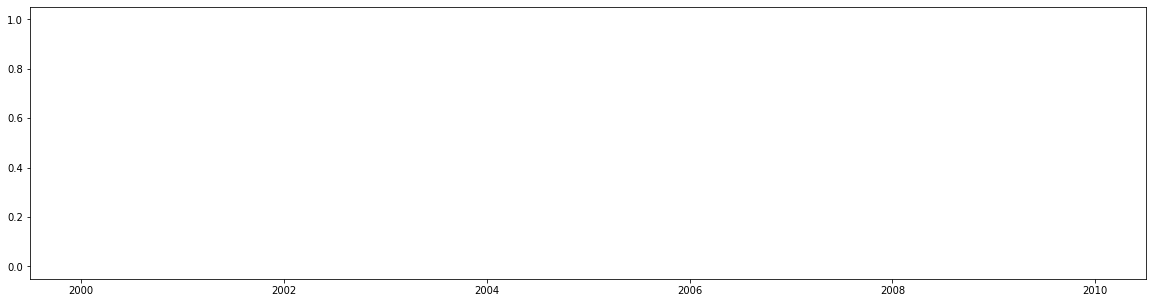

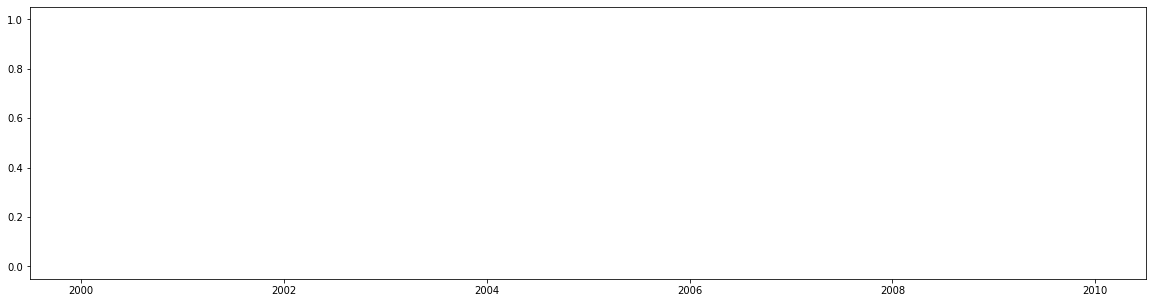

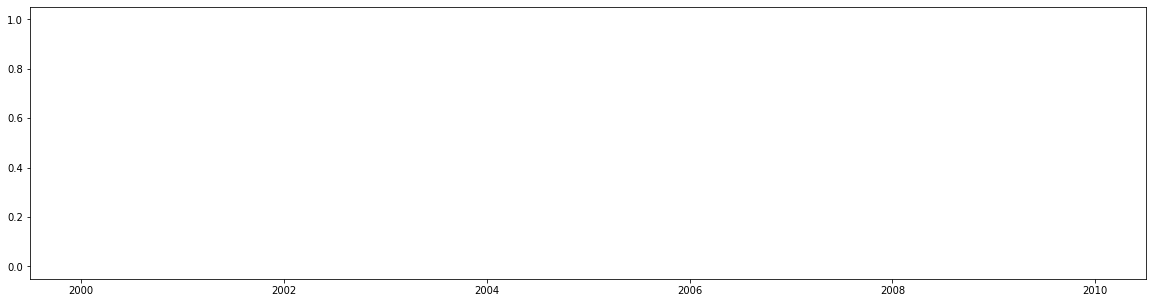

In [19]:
x_values = train_data.loc[train_data['target']=='high', 'datetime']
y_values = train_data.loc[train_data['target']=='high', 'id_code']
plt.figure(figsize=(20,5))
plt.scatter(x_values, y_values)
x_values = train_data.loc[train_data['target']=='medium', 'datetime']
y_values = train_data.loc[train_data['target']=='medium', 'id_code']
plt.figure(figsize=(20,5))
plt.scatter(x_values, y_values)
x_values = train_data.loc[train_data['target']=='low', 'datetime']
y_values = train_data.loc[train_data['target']=='low', 'id_code']
plt.figure(figsize=(20,5))
plt.scatter(x_values, y_values)

### Plotting the data to see the trends with respect to time(it is clear that the relationship is varying)

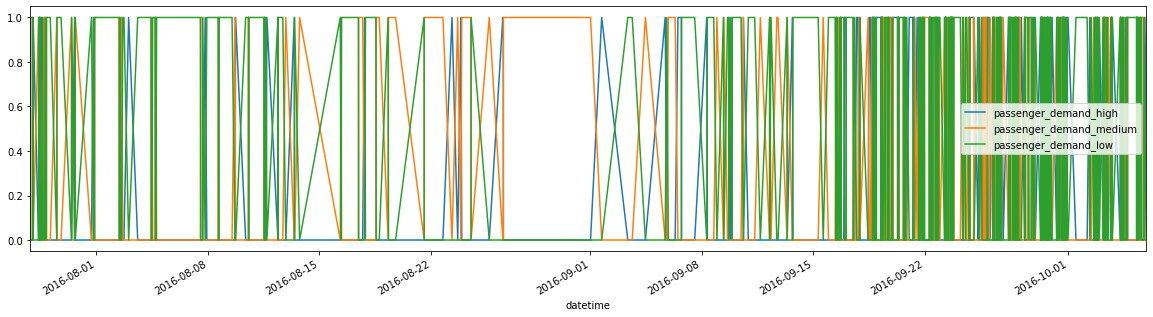

In [20]:
train_data.groupby('datetime')[['passenger_demand_high', 'passenger_demand_medium', 'passenger_demand_low']].mean().plot(figsize=(20,5))

### Calculating the probabilities of each train to be high, medium and low in demand

In [21]:
trains_df = train_data.groupby(['train_name'])['passenger_demand_high', 'passenger_demand_medium', 'passenger_demand_low'].mean()
trains_df.columns = ['train_high_prob', 'train_medium_prob', 'train_low_prob']

### Adding the train probabilities into training data

In [22]:
trains_df.reset_index(inplace=True)
train_data = train_data.merge(trains_df, left_on='train_name', right_on = 'train_name', how='left')

### Calculating the probabilities of each source and destination station to be high, medium and low in demand

In [23]:
stations_df = train_data.groupby(['source_name', 'destination_name'])['passenger_demand_high', 'passenger_demand_medium', 'passenger_demand_low'].mean()
stations_df.columns = ['station_high_prob', 'station_medium_prob', 'station_low_prob']

### Adding the station probability data into training data 

In [24]:
stations_df.reset_index(inplace=True)
train_data = train_data.merge(stations_df, left_on=['source_name', 'destination_name'], right_on = ['source_name', 'destination_name'], how='left')

### Calculating the probabilities of each day to be high, medium and low in demand

In [25]:
days_df = train_data.groupby(['current_day'])['passenger_demand_high', 'passenger_demand_medium', 'passenger_demand_low'].mean()
days_df.columns = ['day_high_prob', 'day_medium_prob', 'day_low_prob']

### Adding the day probability data into training data 

In [26]:
days_df.reset_index(inplace=True)
train_data = train_data.merge(days_df, left_on='current_day', right_on = 'current_day', how='left')

### Calculating the probabilities of each hour to be high, medium and low in demand

In [27]:
hours_df = train_data.groupby(['hours'])['passenger_demand_high', 'passenger_demand_medium', 'passenger_demand_low'].mean()
hours_df.columns = ['hour_high_prob', 'hour_medium_prob', 'hour_low_prob']

### Adding the hour probability data into training data 

In [28]:
hours_df.reset_index(inplace=True)
train_data = train_data.merge(hours_df, left_on='hours', right_on = 'hours', how='left')

### Analysing the trends in source and destination country

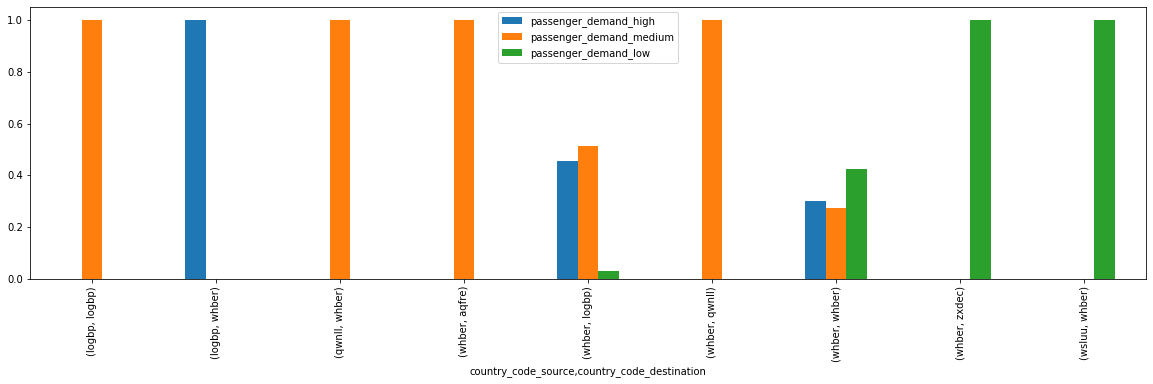

In [29]:
train_data.groupby(['country_code_source', 'country_code_destination' 
                   ])['passenger_demand_high', 'passenger_demand_medium', 'passenger_demand_low'].mean().plot.bar(figsize=(20, 5))

### Calculating the probabilities of each souce and destination country to be high, medium and low in demand

In [30]:
countries_df = train_data.groupby(['country_code_source', 'country_code_destination' 
                   ])['passenger_demand_high', 'passenger_demand_medium', 'passenger_demand_low'].mean()
countries_df.columns = ['country_high_prob', 'country_medium_prob', 'country_low_prob']

### Adding the Country probability data into training data 

In [31]:
countries_df.reset_index(inplace=True)
train_data = train_data.merge(countries_df, left_on=['country_code_source', 'country_code_destination'], right_on = ['country_code_source', 'country_code_destination'], how='left')

### Transformong and Adding extra features to test data

In [32]:
test_data['current_day'] = test_data['datetime'].dt.weekday.astype(int)
test_data['hours'] = test_data['datetime'].dt.hour.astype(int)
test_data['minutes'] = test_data['datetime'].dt.minute.astype(int)
test_data['sec'] = test_data['datetime'].dt.second.astype(int)
test_data['is_weekend'] = (test_data['is_weekend']*1).astype(int)
test_data['distance_between_stations'] = get_distance(test_data['latitude_source'].values, test_data['longitude_source'].values, 
                                                       test_data['latitude_destination'].values, test_data['longitude_destination'].values)

In [33]:
test_data = test_data.merge(trains_df, left_on='train_name', right_on='train_name', how='left')
test_data = test_data.merge(stations_df, left_on=['source_name', 'destination_name'], right_on=['source_name', 'destination_name'], how='left')
test_data = test_data.merge(days_df, left_on='current_day', right_on = 'current_day', how='left')
test_data = test_data.merge(hours_df, left_on='hours', right_on = 'hours', how='left')
test_data = test_data.merge(countries_df, left_on=['country_code_source', 'country_code_destination'], right_on = ['country_code_source', 'country_code_destination'], how='left')

### Updating the missing probabilities in testing data with default probability (1/3) 

In [34]:
test_na_cols = test_data.columns[test_data.isna().sum()>0]
test_data[test_na_cols] = test_data[test_na_cols].fillna(1/3)

### Scaling the numerical feature columns to fit the model 

In [35]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler().fit(train_data[['mean_halt_times_source', 'mean_halt_times_destination', 'distance_between_stations']])
train_data.loc[:,['mean_halt_times_source', 'mean_halt_times_destination', 'distance_between_stations']] = scale.transform(train_data[['mean_halt_times_source', 'mean_halt_times_destination', 'distance_between_stations']])
test_data.loc[:,['mean_halt_times_source', 'mean_halt_times_destination', 'distance_between_stations']] = scale.transform(test_data[['mean_halt_times_source', 'mean_halt_times_destination', 'distance_between_stations']])                             

### Preparing the datasets for train and validation

In [36]:
train_columns = ['train_high_prob', 'train_low_prob', 'train_medium_prob', 'station_high_prob', 'station_medium_prob', 
                 'station_low_prob', 'hour_high_prob', 'hour_medium_prob', 'day_high_prob', 'day_medium_prob', 'day_low_prob', 
                 'hour_low_prob', 'mean_halt_times_source', 'mean_halt_times_destination', 'country_high_prob', 
                 'country_medium_prob', 'country_low_prob', 'is_weekend', 'distance_between_stations'] 
X = train_data[train_columns]
Y = train_data['target']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.4, stratify=Y)

### Analysing with Random Forest Classifier Model

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score
rf_clf = RandomForestClassifier()
rf_clf.fit(x_train, y_train)
print(rf_clf.score(x_train, y_train))
print(rf_clf.score(x_test, y_test))

0.9805194805194806
0.8501945525291829


D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [38]:
print(confusion_matrix(rf_clf.predict(x_test), y_test))
print(f1_score(rf_clf.predict(x_test), y_test, average='macro'))

[[190  18  10]
 [ 13 111  11]
 [ 10  15 136]]
0.8442384567745199


In [39]:
submission = {}
submission['id_code'] = test_data['id_code']
test_pred = rf_clf.predict(test_data[train_columns])
submission['target']=np.where(test_pred==0, 'low', np.where(test_pred==1, 'medium', 'high'))
submission=pd.DataFrame(submission)
print(np.unique(submission['target'], return_counts=True))
submission.to_csv(cwd + "/submission_v1.csv", index=False)

(array(['high', 'low', 'medium'], dtype=object), array([248, 263, 453], dtype=int64))


### Analysing with Extra Trees Classifier Model 

In [40]:
from sklearn.ensemble import ExtraTreesClassifier
et_clf = ExtraTreesClassifier(criterion='entropy', n_estimators=30, bootstrap=True, max_features=None, max_depth=7, max_leaf_nodes=7)
et_clf

ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                     max_depth=7, max_features=None, max_leaf_nodes=7,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [41]:
et_clf.fit(x_train, y_train)
print(et_clf.score(x_train, y_train))
print(et_clf.score(x_test, y_test))

0.8935064935064935
0.8618677042801557


In [42]:
print(confusion_matrix(et_clf.predict(x_test), y_test))
print(f1_score(et_clf.predict(x_test), y_test, average='macro'))

[[188  15   5]
 [ 13 115  12]
 [ 12  14 140]]
0.856614619633309


In [43]:
test_pred = et_clf.predict(test_data[train_columns])
submission['target']=np.where(test_pred==0, 'low', np.where(test_pred==1, 'medium', 'high'))
print(np.unique(submission['target'], return_counts=True))
submission.to_csv(cwd + "/submission_v2.csv", index=False)

(array(['high', 'low', 'medium'], dtype=object), array([528, 185, 251], dtype=int64))


### Analysing with Logistic Regression Model

In [44]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(C=0.01, multi_class='multinomial', solver='lbfgs', max_iter=100)
log_reg

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
log_reg.fit(x_train, y_train)
print(log_reg.score(X, Y))
print(log_reg.score(x_test, y_test))
print(confusion_matrix(log_reg.predict(x_test), y_test))
print(f1_score(log_reg.predict(x_test), y_test, average='macro'))

0.866822429906542
0.8443579766536965
[[200  27  16]
 [  6 103  10]
 [  7  14 131]]
0.8361197948542588


In [46]:
#Only Logistic Regression
test_pred = log_reg.predict(test_data[train_columns])
submission['target']=np.where(test_pred==0, 'low', np.where(test_pred==1, 'medium', 'high'))
print(np.unique(submission['target'], return_counts=True))
submission.to_csv(cwd + "/submission_v3.csv", index=False)

(array(['high', 'low', 'medium'], dtype=object), array([266, 531, 167], dtype=int64))


### Analysing with LGBM (Light Gradient Boosting Model) 

In [47]:
train_columns = ['train_high_prob', 'train_low_prob', 'train_medium_prob', 'station_high_prob', 'station_medium_prob', 
                 'station_low_prob', 'country_high_prob', 
                 'country_medium_prob', 'country_low_prob'] 
X = train_data[train_columns]
Y = train_data['target']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.4, stratify=Y)

In [48]:
import lightgbm as lgb
params = {
            'boosting_type': 'gbdt',
            'objective': 'multiclass',
            'num_class':3,
            'metric': {'multi_logloss'},
            'subsample': 0.7,
            'learning_rate': 0.04,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'pos_bagging_fraction':0.7,
            'neg_bagging_fraction':0.3,
            'bagging_freq':10,
            'is_unbalance':True,
            'num_leaves': 16,
            'max_depth': 5,
            'random_state':3
            }

lgb_train = lgb.Dataset(X, Y)
lgb_eval = lgb.Dataset(x_test, y_test)
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=2000,
                valid_sets=(lgb_train, lgb_eval),
               early_stopping_rounds=100,
               verbose_eval = 100)

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.211846	valid_1's multi_logloss: 0.19554
[200]	training's multi_logloss: 0.17009	valid_1's multi_logloss: 0.155928
[300]	training's multi_logloss: 0.144506	valid_1's multi_logloss: 0.129739
[400]	training's multi_logloss: 0.131719	valid_1's multi_logloss: 0.118849
[500]	training's multi_logloss: 0.123414	valid_1's multi_logloss: 0.114458
[600]	training's multi_logloss: 0.117911	valid_1's multi_logloss: 0.106791
[700]	training's multi_logloss: 0.113675	valid_1's multi_logloss: 0.108904
Early stopping, best iteration is:
[650]	training's multi_logloss: 0.116219	valid_1's multi_logloss: 0.106029


In [49]:
from sklearn.metrics import accuracy_score
print(confusion_matrix(np.argmax(gbm.predict(x_test), axis=1), y_test))
print("F1 Score : ",f1_score(np.argmax(gbm.predict(x_test), axis=1), y_test, average='macro'))
print("Accuracy Score : ", accuracy_score(np.argmax(gbm.predict(x_test), axis=1), y_test))

[[204   2   4]
 [  3 135   4]
 [  6   7 149]]
F1 Score :  0.9475880767150026
Accuracy Score :  0.9494163424124513


In [50]:
test_pred = np.argmax(gbm.predict(test_data[train_columns]), axis=1)
submission['target']=np.where(test_pred==0, 'low', np.where(test_pred==1, 'medium', 'high'))
print(np.unique(submission['target'], return_counts=True))
submission.to_csv(cwd + "/submission_v4.csv", index=False)

(array(['high', 'low', 'medium'], dtype=object), array([510, 231, 223], dtype=int64))
